# Two-dimensional shallow water equations
### v1.42, 3 March 2016, by Brian Fiedler
### Modifications by Joseph France


**This should be the final version, for tasks due on Friday March 11, 2016**

We consider these *dimensionless* two-*dimensional* shallow-water equations:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} 
+ v \frac{\partial u}{\partial y}= - \frac{\partial h}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} 
+ v \frac{\partial v}{\partial y}= - \frac{\partial h}{\partial y} - fu
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

#### As explained in the previous notebook, the $^*$ to designate a variable to be dimensionless has been dropped, and left as implied. The above $f$ is acutally $f^*$, and is related to the familiar Coriolis parameter $f$ by:

$$
f^* = \frac{L}{\sqrt{gH}} f
$$

The boundary conditions for $u(x,y,t)$, $v(x,y,t)$ and $h(x,y,t)$ are:

$$
u(0,y,t)=0 \qquad u(1,y,t)=0 \qquad v(x,0,t)=0 \qquad v(x,1,t)=0
$$

$$
\frac{\partial h}{\partial x}(0,y,t)=0 \qquad \frac{\partial h}{\partial x}(1,y,t)=0
\qquad \frac{\partial h}{\partial y}(x,0,t)=0 \qquad \frac{\partial h}{\partial y}(x,1,t)=0
$$



In [713]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
HTML( open('my_css.css').read() )

In [714]:
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

In [715]:
# dqdt requires a list of the time derivatives for q, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported") 
              
def forback(q,dt,dqdt,dx,dy,fcoriolis): #q = [u,v,h], dqdt = [dudta[0],dvdta[0],dhdta[0]]
    hn = q[2] + dt*dqdt[2]
    un = q[0] + dt*dqdt[0]
    vn = q[1] + dt*dqdt[1]
    hun = p2u(hn) # calculate h on the u grid
    dhdtn = -divergence(un*hun,vn*hun,dx,dy)
    dudtn,dvdtn = pgf(hn,dx,dy) #pressure gradient force
    dudtn += advect3(un,un,vn,dx,dy,'u') # no option for other than 3rd order 
    dvdtn += advect3(vn,un,vn,dx,dy,'v')
    dudtn += fcoriolis*vn
    dvdtn += -fcoriolis*un
    dvdtn[0,:]=0.
    dvdtn[-1,:]=0.
    h = q[2] + dt*dhdtn
    u = q[0] + dt*dudtn
    v = q[1] + dt*dvdtn
    return [u,v,h]            

In [771]:
##############################################90% SURE THIS IS CORRECT
def p2u(p):
# interpolates and extrapolates from the p-grid to the u-grid
    u=np.zeros((p.shape[0]+1,p.shape[1]+1))
    u[1:-1,1:-1] = .25*( p[:-1,:-1]+p[1:,:-1]+p[1:,1:]+p[:-1:,1:] )
    u[1:-1,-1] = .25* (p[:-1,0] + p[1:,0] + p[:-1,-1] + p[1:,-1]) #Periodic?
    u[1:-1,0] = u[1:-1,-1]
    u[0,1:-1] = .5* (p[0,:-1] + p[0,1:]) #Fixed
    u[-1,1:-1] = .5* (p[-1,:-1] + p[-1,1:]) #Fixed
    u[0,0]= .5* (p[0,-1] + p[0,0]) #Fixed in vert, periodic in horiz
    u[-1,0]= .5* (p[-1,-1] + p[-1,0])
    u[0,-1]= u[0,0]
    u[-1,-1]= u[-1,0]
    return u
############################################################# CORRECT
def u2p(u):
# interpolates u-grid to the p-grid
    return .25*( u[:-1,1:] + u[1:,1:] + u[:-1,:-1] + u[1:,:-1])
############################################################# CORRECT
def divergence(u,v,dx,dy):
    div = .5*( u[:-1,1:] + u[1:,1:] - u[:-1,:-1] - u[1:,:-1])/dx + .5*( v[1:,:-1] + v[1:,1:] - v[:-1,:-1] - v[:-1,1:])/dy
    return div
############################################################# CORRECT
#STUDENTS: complete the vorticity function, which is very similar to divergence
def vorticity(u,v,dx,dy):
    vor = .5*( v[:-1,1:] + v[1:,1:] - v[:-1,:-1] - v[1:,:-1])/dx - .5*( u[1:,:-1] + u[1:,1:] - u[:-1,:-1] - u[:-1,1:])/dy
    return vor
#########################################################################NEW VERSION SHOULD BE CORRECT
# third-order upwind advection
def advect3Old(q,u,v,dx,dy): 
    
    dqdt=np.zeros(q.shape)
    
    dqmx=np.zeros(q.shape)
    dqpx=np.zeros(q.shape)
    dqmy=np.zeros(q.shape)
    dqpy=np.zeros(q.shape)
    
    #Upwind
    #dqmx[:,1] = -q[:,0] + q[:,1]
    dqmx[:,-1] = (q[:,-3] - 6*q[:,-2] + 3*q[:,-1] + 2*q[:,1])/6. 
    dqmx[:,0] = dqmx[:,-1]
    dqmx[:,1] = (q[:,-2] - 6*q[:,-1] + 3*q[:,1] + 2*q[:,2])/6. 
    dqmx[:,2] = (q[:,-1] - 6*q[:,1] + 3*q[:,2] + 2*q[:,3])/6. 
    dqmx[:,3:-1] = (q[:,1:-3] - 6*q[:,2:-2] + 3*q[:,3:-1] + 2*q[:,4:])/6. 
    
    #Downwind
    #dqpx[:,-2] = -q[:,-2] + q[:,-1] # 1st order (upwind side at right wall)
    dqpx[:,-2] = (-2*q[:,-3] - 3*q[:,-2] + 6*q[:,-1] -1*q[:,1])/6. 
    dqpx[:,-1] = (-2*q[:,-2] - 3*q[:,-1] + 6*q[:,1] -1*q[:,2])/6.
    dqpx[:,0] = dqpx[:,-1]
    dqpx[:,1] = (-2*q[:,-1] - 3*q[:,1] + 6*q[:,2] -1*q[:,3])/6. 
    dqpx[:,2:-2] = (-2*q[:,1:-3] - 3*q[:,2:-2] + 6*q[:,3:-1] -1*q[:,4:])/6. 

    dqmy[1,:]  = -q[0,:] + q[1,:] # 1st order (upwind side at bottom wall)
    dqmy[2:-1,:] =  (q[:-3,:] - 6*q[1:-2,:] + 3*q[2:-1,:] + 2*q[3:,:])/6. # 3rd order, minus side
    dqpy[-2,:] = -q[-2,:] + q[-1,:] # 1st order (upwind side at top wall)
    dqpy[1:-2,:] = ( - 2*q[0:-3,:]  - 3*q[1:-2,:] + 6*q[2:-1,:] - q[3:,:] )/6. # 3rd order, plus side

    dqdx=np.where(u>0.,dqmx,dqpx)/dx # upwind, emphasize side from where fluid is coming from
    dqdy=np.where(v>0.,dqmy,dqpy)/dy # ditto
    
    dqdt += -u*dqdx
    dqdt += -v*dqdy
    
    return dqdt

def advect3(q,u,v,dx,dy,periodic=False): 
# 3rd-order upwind advection
# q,u,v are co-located
    sh = q.shape
    Q = np.zeros( (sh[0],sh[1]+4) )
    Q[:, 2:-2 ] = q
     
    if periodic=='U' or periodic=='u':        
        Q[ : , :2] = q[ : , -3:-1 ]
        Q[ : , -2:] = q[ :, 1:3 ]
    elif periodic=='v' or periodic=='w' or periodic=='b':
        Q[ : , :2 ]  = q[ : , -2: ]
        Q[ : , -2: ] = q[ : , :2 ] 
    
    dqdt=np.zeros(sh)
    dqmx=np.zeros(sh)
    dqpx=np.zeros(sh)
    dqmy=np.zeros(sh)
    dqpy=np.zeros(sh)

# "m" is difference biased to the minus side, "p" to the plus side
# must use first order "#1" if too close to wall
    
    dqmx[:,:] =  (2*Q[:,3:-1] + 3*Q[:,2:-2] - 6*Q[:,1:-3] + Q[:,:-4])/6. 
    dqpx[:,:] = -(2*Q[:,1:-3] + 3*Q[:,2:-2] - 6*Q[:,3:-1] + Q[:,4:] )/6.

    dqmy[1,:]  = q[1,:]-q[0,:]  #1
    dqmy[2:-1,:] = (2*q[3:,:]+3*q[2:-1,:]-6*q[1:-2,:]+q[:-3,:])/6. #3
    dqpy[-2,:] = q[-1,:]-q[-2,:] #1
    dqpy[1:-2,:] = -(2*q[0:-3,:]+3*q[1:-2,:]-6*q[2:-1,:]+q[3:,:])/6. #3

# use derivatives biased to the upwind side:
    dqdx=np.where(u>0.,dqmx,dqpx)/dx
    dqdy=np.where(v>0.,dqmy,dqpy)/dy

# advective terms:
    dqdt+=-u*dqdx
    dqdt+=-v*dqdy
    
    return dqdt
#####################################Corners are broken, but the periodicity works
def pgfOld(p,dx,dy):
# calculated pressure gradient force on the u-grid
# note calculation on the boundaries assume pressure gradient force
# along boundary is the same as calculated 1/2 a grid point away from the boundary
    dudt=np.zeros( (p.shape[0]+1, p.shape[1]+1 ) ) #initialize an array on the u-grid
    dvdt=np.zeros( dudt.shape ) # ditto

    dpy =  p[1:,:]-p[:-1,:] # delta p in the x direction
    dvdt[1:-1,1:-1] = -.5* ( dpy[:,:-1] + dpy[:,1:] ) /dy #average to put on u-grid
    dvdt[1:-1,0] =  -dpy[:,0] /dy #dvdt along left boundary
    dvdt[1:-1,-1] = dvdt[1:-1,0]
    #dvdt[1:-1,-1] = -dpy[:,-1] /dy #dvdt along right boundary

    dpx = p[:,1:]-p[:,:-1] # delta p in the y direction
    dudt[1:-1,1:-1] = -.5* ( dpx[:-1,:] + dpx[1:,:] ) /dx #average to put on u-grid
    dudt[1:-1,0] =  -.5* ( dpy[:,-1] + dpy[:,1] ) /dy #dvdt along left boundary
    dudt[1:-1,-1] = dudt[1:-1,0] #dvdt along right boundary
    #dudt[0,1:-1] =  -dpx[0,:] /dx #dudt along bottom boundary
    #dudt[-1,1:-1] = -dpx[-1,:] /dx #dudt along top boundary

    return dudt,dvdt

def pgf(p,dx,dy): 

    dudt=np.zeros( (p.shape[0]+1, p.shape[1]+3) )
    #dudt=np.zeros( (p.shape[0]+1, p.shape[1]+1) )
    dvdt=np.zeros( dudt.shape )
    
    P = np.zeros( (p.shape[0] , p.shape[1]+2 ) )
    P[:,1:-1] = p
    P[:,0] = p[:,-1]
    P[:,-1] = p[:,0]
    
    dpx = (P[:,1:]-P[:,:-1])/dx 
    dudt[1:-1,1:-1] = -.5*(dpx[1:,:] + dpx[:-1,:])   
    dudt[1:-1,-1] = -.5*(dpx[1:,-1] + dpx[:-1,1])
    dudt[1:-1,0] = dudt[1:-1,-1]
    dudt[1,1] = -.5*(dpx[1,1] + dpx[2,1])
    dudt[1,-2] = dudt[-2,1] = dudt[-2,-2] = dudt[1,1]
    
    dpy =  (P[1:,:]-P[:-1,:])/dy 
    dvdt[1:-1,1:-1] = -.5*(dpy[:,1:] + dpy[:,:-1])    
    dvdt[-1,1:-1] = -dpy[-1,1:] /dy
    dvdt[0,1:-1] = -dpy[0,1:] /dy
    dvdt[1,1] = -.5*(dpy[1,1] + dpy[1,2])
    dvdt[1,-2] = dvdt[-2,1] = dvdt[-2,-2] = dvdt[1,1]
    
    return dudt[:,1:-1],dvdt[:,1:-1] #[1:-1,1:-1]

In [772]:
# make the grid
Nx = 101 # number of x grid points for u
Ny = 101
xmax = 1. # 0 <= x <= xmax
ymax = 1.
dx = xmax/(Nx-1.) # grid width
dy = ymax/(Ny-1.)
x1u = np.linspace(0,xmax,Nx)
y1u = np.linspace(0,ymax,Ny)
x1p = .5*(x1u[:-1]+x1u[1:])
y1p = .5*(y1u[:-1]+y1u[1:])
# We need 2-D arrays of grid point coordinates, for plotting:
xu,yu = np.meshgrid(x1u,y1u) # x and y locations on the u-grid
xp,yp = np.meshgrid(x1p,y1p) # x and y locations on the p-grid

In [773]:
print(xu.shape)
print(xu)

(101, 101)
[[ 0.    0.01  0.02 ...,  0.98  0.99  1.  ]
 [ 0.    0.01  0.02 ...,  0.98  0.99  1.  ]
 [ 0.    0.01  0.02 ...,  0.98  0.99  1.  ]
 ..., 
 [ 0.    0.01  0.02 ...,  0.98  0.99  1.  ]
 [ 0.    0.01  0.02 ...,  0.98  0.99  1.  ]
 [ 0.    0.01  0.02 ...,  0.98  0.99  1.  ]]


In [774]:
print(xp.shape)
print(xp)

(100, 100)
[[ 0.005  0.015  0.025 ...,  0.975  0.985  0.995]
 [ 0.005  0.015  0.025 ...,  0.975  0.985  0.995]
 [ 0.005  0.015  0.025 ...,  0.975  0.985  0.995]
 ..., 
 [ 0.005  0.015  0.025 ...,  0.975  0.985  0.995]
 [ 0.005  0.015  0.025 ...,  0.975  0.985  0.995]
 [ 0.005  0.015  0.025 ...,  0.975  0.985  0.995]]


In [775]:
print(yu.shape)
print(yu)

(101, 101)
[[ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
 [ 0.02  0.02  0.02 ...,  0.02  0.02  0.02]
 ..., 
 [ 0.98  0.98  0.98 ...,  0.98  0.98  0.98]
 [ 0.99  0.99  0.99 ...,  0.99  0.99  0.99]
 [ 1.    1.    1.   ...,  1.    1.    1.  ]]


Note the convention of meshgrid and matplotlib:  The **first** index controls the variation of $y$, the **second** index controls the variation of $x$. That protocol will also be true for all of our 2-D fields. This may be confusing because when normally write $h(x,y)$ we might expect in a python array `h[j,i]` that `i` controls the y-coordinate, but in fact `i` controls the x-coordinate.

In [776]:
print("x:" ,xu[1,1], xu[1,2])
print("y:" ,yu[1,1], yu[1,2])

x: 0.01 0.02
y: 0.01 0.01


In [777]:
def yhat(y,yc,w):
    return (y-yc)/w

In [778]:
beta = 10.
# initialize u, v, h
xc = .5*xmax # center of initial 
yc = .5*ymax # center of iniital 
w = .2 #half width of the jet
uo = .2 #max verlocity of jet
ho = 1 #minimum height
pshape = yp.shape
ushape = yu.shape

uyhat = yhat(yu,yc,w)
pyhat = yhat(yp,yc,w)

#initial v
vi = 0.*xu 

#initial u
for ycor in range(ushape[0]):
    for xcor in range(ushape[1]):
        uyv = uyhat[ycor,xcor]
        if uyv >= -1 and uyv <= 1:
            ui[ycor,xcor] = uo*(1-3*uyv**2 + 3*uyv**4 - uyv**6)
        else:
            ui[ycor,xcor] = 0
        
#initial h
for ycor in range(pshape[0]):
    for xcor in range(pshape[1]):
        pyv = pyhat[ycor,xcor]
        if pyv <= -1 :
            hi[ycor,xcor] = ho
        elif pyv <= 1 and pyv >= -1 :
            hi[ycor,xcor] = ho - (w*beta*uo)*(yc*((16/35)+pyv-pyv**3+(3/5)*pyv**5-(1/7)*pyv**7)+w*((-1/8)+(1/2)*pyv**2-(3/4)*pyv**4+(1/2)*pyv**6-(1/8)*pyv**8))
        else:
            hi[ycor,xcor] = ho - (32/35)*(w*beta*uo*yc)

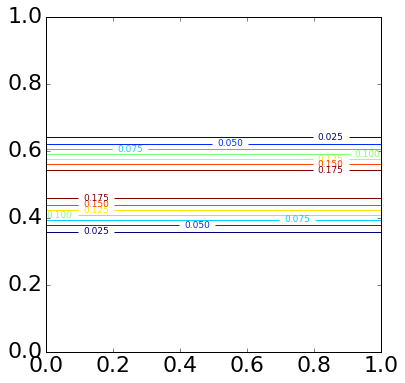

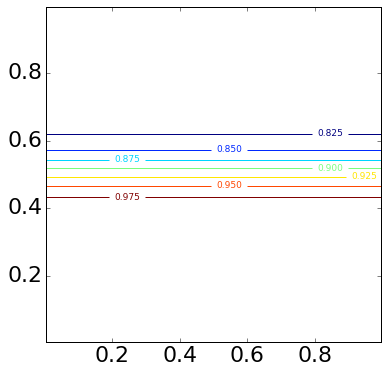

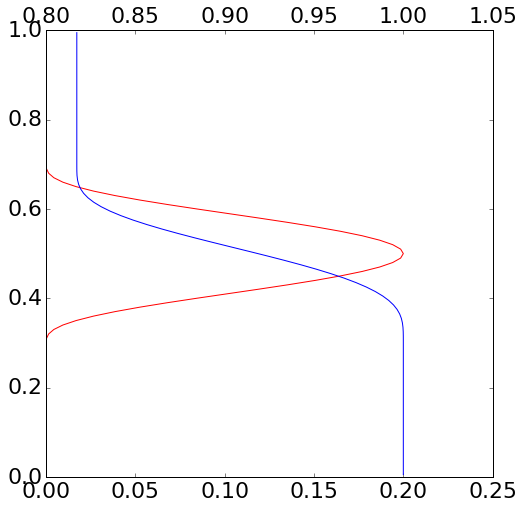

In [779]:
quicku,simpleu = plt.subplots(figsize=(6,6))
CHu = simpleu.contour(xu,yu,ui) #must assign a variable name to the contour plot
plt.clabel(CHu, fontsize=9, inline=1)
quickh,simpleh = plt.subplots(figsize=(6,6))
CHh = simpleh.contour(xp,yp,hi) #must assign a variable name to the contour plot
plt.clabel(CHh, fontsize=9, inline=1)
quickb,simpleb1 = plt.subplots(figsize=(8,8))
simpleb1.plot(ui[:,2],yu[:,2],'r-')
simpleb2 = simpleb1.twiny()
simpleb2.plot(hi[:,2],yp[:,2],'b-');

#plt.savefig('contours.png')

In [780]:
# needed for contour plots of h in the animation:
lowc = .75 #lowest contour
hic = 1.25 #highest contour
dc = .02  #contour increment
mylevs = [] #store contours
lev = lowc
while lev < hic + 0.1*dc:
    mylevs.append(lev)
    lev += dc
    
#for arrow plots:
vd = 2 # vector skip (vd=1 plots all arrows)
speedmax = 0.05 # anticipated maximum speed

In [781]:
#fcoriolis = 1
fcoriolis = beta*yu[:,:]
cphase = 1.
u_est = 0.6
dtlim = 0.2 # fraction of a grid space a wave is allowed to travel in one time unit
dt = (dtlim *dx)/max(cphase,u_est)
#dt = dtlim *dx # because wave speed is 1

fdt_crit = 0.5 #determined by experimentation, crit value when dtlim = 0.2

dt = min(fdt_crit/beta,dt) #force fdt <= fdt_crit 

tstop = 500 # stop when t>tstop
dplot = 10. # time increment between plots

#Variable Stepping
nsteps = tstop / dt
mult = 2 #lambda^nsteps
c = mult**(1/nsteps)
dti = tstop*((c-1)/(mult-1))

aborder = 3 # Adams-Bashforth order: 1, 2 or 3 [Set to 10 for Forwards-Backwards
varStep = True
if aborder != 10:
    varStep = False
expt = '%d,%3.2f,%5.2f,%d' % (aborder, dtlim, beta, Ny)
print(expt)
print(beta,dt,dt*beta)

3,0.20,10.00,101
10.0 0.002 0.02


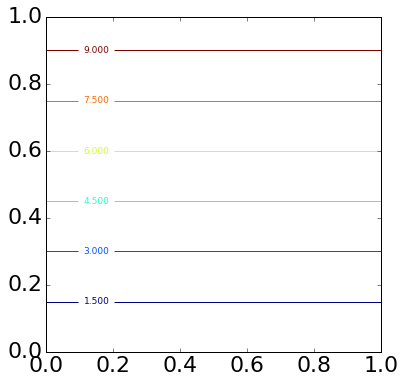

In [782]:
quick,simple3 = plt.subplots(figsize=(6,6))
CH3 = simple3.contour(xu,yu,fcoriolis) #must assign a variable name to the contour plot
plt.clabel(CH3, fontsize=9, inline=1);

In [783]:
def plot(xp,yp,h,mylevs,xu,vd,yu,u,ymax,xmax,v,speedmax,expt):
    ax2.clear()
    CF=ax2.contourf(xp,yp,h,mylevs,zorder=1)
    ax2.axis('off')
    Q=ax2.quiver(xu[::vd,::vd],yu[::vd,::vd],u[::vd,::vd]*ymax/xmax,v[::vd,::vd],
        scale=speedmax*Nx/vd,units='width',zorder=3) #normally ymax/xmax =1 
    stop_clipping(ax2)
    ax2.quiverkey(Q,-.1,.95,speedmax,'{0:7.3f}'.format(speedmax),zorder=4)
    ax2.text(.5,-.05,expt,fontsize=22)
    ax2.text(.05,-.05,'t={0:5.3f}'.format(t),fontsize=22) 
    if t<dt/2.: 
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.4)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        for boomer in sooner:
            boomer.set_fontsize(12)
    clear_output(wait=True)
    display(myfig) 
    myfig.savefig('AAAA_'+str(int(t))+'_time.png')
    #Time.sleep(2.)

##  Notes about the simulation below.

* Note that wind vectors only every 2nd grid point is plotted, meaning that there are 2 times as many grid points as displayed vectors.  

* The simulation is a bit slow to compute. One reason is that the time step is limited by the gravity waves, which move with speed of 1. 

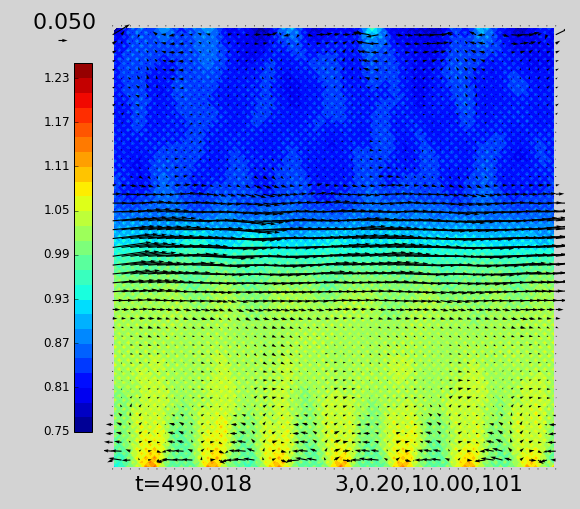

In [784]:
t=0
tplot=-100. # next time to make a plot
u=ui.copy()
v=vi.copy()
h=hi.copy()

dudt = 0.*u
dvdt = 0.*v
dhdt = 0.*h
dundt = 0.*u
dvndt = 0.*v
dhndt = 0.*h

dhdta = [None]*3
dudta = [None]*3
dvdta = [None]*3

nstep = 0
myfig = plt.figure(figsize=(8,8),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.1, 0.8, .8*ymax/xmax],frameon=False) # contour axes
ax3 = myfig.add_axes([0.0, 0.1, 0.08, .8]) # for colorbar
ax3.axis('off')
ax2.axis('off')
plt.setp( ax2.get_xticklabels(), visible=False);

nxc=Nx//2
nyc=Ny//2
#hstore = [ ]
hstore = [h[nyc,nxc]]
zetastore = [ vorticity(u,v,dx,dy)[50,50] ]
tstore = [ 0 ] # for storing the corresponding time of the value

if aborder == 10:
    dt = dti

while t < tstop + dt/2.:
    nstep+=1
    abnow=min(nstep,aborder)
    if t >= tplot + dplot: #plot
        plot(xp,yp,h,mylevs,xu,vd,yu,u,ymax,xmax,v,speedmax,expt)
        tplot = t
    
    hu = p2u(h) # calculate h on the u grid
    
    dhdt = -divergence(u*hu,v*hu,dx,dy)
    
    dudt,dvdt = pgf(h,dx,dy) #pressure gradient force
    
    dudt += advect3(u,u,v,dx,dy,'u') # no option for other than 3rd order 
    dvdt += advect3(v,u,v,dx,dy,'v') 
    
#Coriolis force here:
    dudt += fcoriolis*v
    dvdt += -fcoriolis*u
    dvdt[0,:]=0.
    dvdt[-1,:]=0.
#end Coriolis force
    
    dudta = [dudt.copy()] + dudta[:-1]
    dvdta = [dvdt.copy()] + dvdta[:-1]
    dhdta = [dhdt.copy()] + dhdta[:-1]
    
    if aborder == 10: #FORWARDS BACKWARDS
        fba = forback([u,v,h],dt,[dudta[0],dvdta[0],dhdta[0]],dx,dy,fcoriolis)
        u = fba[0]
        v = fba[1]
        h = fba[2]
    else: #ADAMS BASHFORTH
        u += dt*ab_blend(dudta,abnow)
        v += dt*ab_blend(dvdta,abnow)
        h += dt*ab_blend(dhdta,abnow)
    
#NRG CONS
#    h2 = h**2
#    u2 = u**2
#    v2 = v**2
#    uh = (u2[:-1,:-1]+u2[1:,1:])/2
#    vh = (v2[:-1,:-1]+v2[1:,1:])/2
#    nrg = (h*uh/2)+(h*vh/2)+(h2/2)
#    hstore.append(nrg.mean())
    
#END NRG CONS


#Monitor vort @ centre
    zeta = vorticity(u,v,dx,dy)
    buns = (zeta[nxc,nyc]+fcoriolis[nxc,nyc])/h[nxc,nyc]
    zetastore.append(buns)
#end monitoring
    
    t = t + dt
    hstore.append(h[nyc,nxc])
    #hstore.append( h.mean() )
    tstore.append( t )
    if varStep == True:
        dt = dt*c
    
    assert u.max()<2.e10, 'kaboom!'

highres = False
if highres == True:
    np.save('HR_u',u)
    np.save('HR_v',v)
    np.save('HR_h',h)
    
    hu = p2u(h) # calculate h on the u grid
    dhdt = -divergence(u*hu,v*hu,dx,dy)
    dudt,dvdt = pgf(h,dx,dy) #pressure gradient force
    dudt += advect3(u,u,v,dx,dy,'u') # no option for other than 3rd order 
    dvdt += advect3(v,u,v,dx,dy,'v') 
    dudt += fcoriolis*v
    dvdt += -fcoriolis*u
    np.save('HR_hu',hu)
    np.save('HR_dhdt',dhdt)
    np.save('HR_dudt',dudt)
    np.save('HR_dvdt',dvdt)
    
    
plt.close() 

In [736]:
print(nstep)

50001


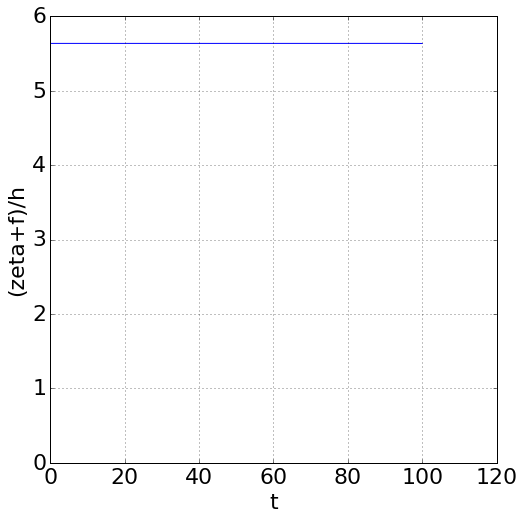

In [737]:
q3,zetaplot = plt.subplots(figsize=(8,8))
zetaplot.plot(tstore,zetastore)
#zetaplot.set_ylim((8,9))
#zetaplot.set_xlim((0,1.75))
zetaplot.set_xlabel('t')
zetaplot.set_ylabel('(zeta+f)/h')
zetaplot.grid()
#q3.savefig('zetacenterstudy.png')

0.913531560428 0.913589921452


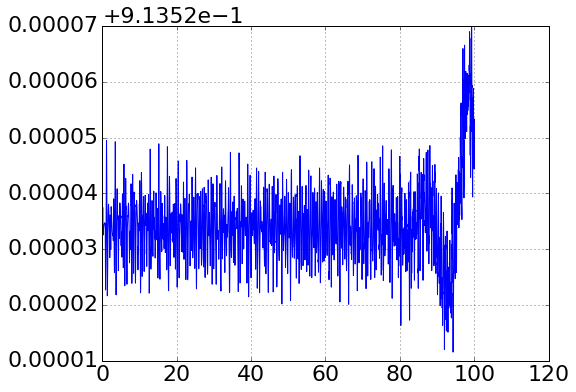

In [738]:
myfig, trace = plt.subplots(figsize=(8,6))
trace.plot(tstore,hstore)
#trace.set_ylim((.8,1.2))
trace.grid()
print(min(hstore),max(hstore))

(0.0, 99.0, 0.0, 99.0)

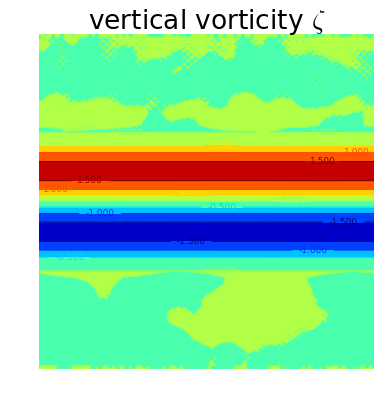

In [739]:
vort=vorticity(u,v,dx,dy) # fix the vorticity function!!
quick,simple = plt.subplots(figsize=(6,6))
# it is possible to use both filled and line contour plots together
simple.contourf(vort) # fiiled contours
CV = simple.contour(vort) # line contours
plt.clabel(CV, fontsize=9, inline=1) #labels on line contours
simple.set_title('vertical vorticity $\zeta$') #fix title
simple.axis('off')             
#quick.savefig("vertvortfix.png")

## Student tasks:

### 1. Derivation of the dimensionless model

Beginning with:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} 
+ v \frac{\partial u}{\partial y}= - g\frac{\partial h}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} 
+ v \frac{\partial v}{\partial y}= - g\frac{\partial h}{\partial y} - fu
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

Let's assume a square domain of dimensional size $L\times L$.
Using the time and length scales that we used for one-dimensional waves,
derive the following dimensionless equations  **using pencil and paper**.
The whole point of this is $g$ disappears and the boundary conditions will always be
at $x=0$,$x=1$,$y=0$ and $y=1$. 

$$
\frac{\partial u^*}{\partial t^*} + u^* \frac{\partial u^*}{\partial x^*} 
+ v^* \frac{\partial u^*}{\partial y^*}= - \frac{\partial h^*}{\partial x^*} + f^*v^*
$$

$$
\frac{\partial v^*}{\partial t^*} + u^* \frac{\partial v^*}{\partial x^*} 
+ v^* \frac{\partial v^*}{\partial y^*}= - \frac{\partial h^*}{\partial y^*} - f^*u^*
$$

$$
\frac{\partial h^*}{\partial t^*} = - \frac{\partial (u^*h^*) }{\partial x^*} - \frac{\partial (v^*h^*) }{\partial y^*}
$$



### 2. Global conservation of energy

Here is a global conserved quantity for two-dimensional shallow-water waves, a generalization of the energy we derived for one-dimensional waves:

$$ \int_{x=0}^{x=L}\int_{y=0}^{y=L} \left( h\frac{u^2}{2} + h\frac{v^2}{2} + g\frac{h^2}{2} \right)dx\, dy $$

The dimensionless version is: 
$$ \int_{x=0}^{x=1}\int_{y=0}^{y=1} \left( h\frac{u^2}{2} + h\frac{v^2}{2} + \frac{h^2}{2} \right)dx\, dy $$

Show the numerical (meaning python array) approximation of the above integral is conserved well in the model.

[0.52636925561494208, 0.52636925613538321, 0.52636925531129186, 0.52636925534560375, 0.52636925512701571, 0.52636925494445586, 0.52636925476358865, 0.52636925458204942, 0.52636925440026017, 0.52636925421805103, 0.52636925403530799, 0.52636925385190803, 0.52636925366771969, 0.52636925348260744, 0.52636925329643303, 0.52636925310905858, 0.52636925292034897, 0.52636925273017354, 0.52636925253840872, 0.52636925234494081, 0.52636925214966679, 0.52636925195249795, 0.52636925175336025, 0.5263692515521966, 0.52636925134896917, 0.52636925114365818, 0.52636925093626652, 0.52636925072681751, 0.52636925051535732, 0.52636925030195436, 0.5263692500867011, 0.52636924986971168, 0.52636924965112275, 0.52636924943109675, 0.52636924920981343, 0.52636924898747661, 0.5263692487643099, 0.52636924854055656, 0.52636924831647647, 0.52636924809234864, 0.52636924786846662, 0.52636924764513959, 0.52636924742268953, 0.52636924720144473, 0.52636924698175258, 0.52636924676396812, 0.52636924654843764, 0.52636924633554216, 0.5263692461256323, 0.52636924591909529, 0.52636924571628929, 0.52636924551759778, 0.52636924532338125, 0.52636924513401551, 0.52636924494986026, 0.52636924477126967, 0.52636924459860324, 0.52636924443219779, 0.52636924427239296, 0.52636924411951058, 0.52636924397386264, 0.52636924383575623, 0.52636924370548188, 0.52636924358330939, 0.52636924346949931, 0.52636924336429802, 0.52636924326794121, 0.52636924318064615, 0.5263692431025816, 0.52636924303394594, 0.52636924297490517, 0.52636924292556408, 0.52636924288606501, 0.52636924285651099, 0.52636924283694519, 0.52636924282746045, 0.52636924282806463, 0.52636924283876874, 0.52636924285958486, 0.52636924289044096, 0.5263692429313177, 0.52636924298210164, 0.5263692430427187, 0.52636924311302868, 0.52636924319288503, 0.52636924328213486, 0.52636924338056368, 0.52636924348799252, 0.52636924360415482, 0.52636924372883509, 0.52636924386173589, 0.52636924400258978, 0.52636924415107622, 0.52636924430688936, 0.52636924446967415, 0.52636924463910395, 0.52636924481478631, 0.5263692449963695, 0.52636924518345118, 0.52636924537563934, 0.52636924557252873, 0.52636924577370903, 0.52636924597875245, 0.52636924618723846, 0.52636924639873484, 0.52636924661280693, 0.52636924682902642, 0.52636924704696308, 0.52636924726619283, 0.52636924748627156, 0.52636924770677285, 0.52636924792727924, 0.52636924814738084, 0.52636924836667276, 0.52636924858475842, 0.52636924880121738, 0.52636924901568671, 0.5263692492277906, 0.526369249437177, 0.52636924964346665, 0.52636924984631961, 0.52636925004541468, 0.52636925024044134, 0.52636925043108185, 0.52636925061702911, 0.526369250798016, 0.5263692509737824, 0.52636925114406241, 0.52636925130860579, 0.52636925146719016, 0.52636925161960679, 0.52636925176565308, 0.52636925190511852, 0.52636925203784901, 0.52636925216367347, 0.52636925228244746, 0.52636925239401733, 0.52636925249826949, 0.52636925259509271, 0.52636925268438295, 0.52636925276604674, 0.52636925284001379, 0.52636925290621772, 0.5263692529646028, 0.52636925301512594, 0.5263692530577555, 0.52636925309247473, 0.52636925311926597, 0.52636925313813077, 0.52636925314908434, 0.52636925315213623, 0.52636925314731819, 0.52636925313467398, 0.52636925311423799, 0.52636925308608351, 0.52636925305028992, 0.52636925300691284, 0.52636925295603232, 0.52636925289773173, 0.52636925283209945, 0.52636925275922386, 0.52636925267920764, 0.52636925259215761, 0.52636925249817901, 0.52636925239738996, 0.52636925228990816, 0.5263692521758575, 0.52636925205536189, 0.5263692519285551, 0.52636925179556426, 0.52636925165652926, 0.52636925151158409, 0.52636925136086721, 0.52636925120451872, 0.52636925104267973, 0.52636925087548914, 0.52636925070308693, 0.52636925052561445, 0.5263692503432118, 0.52636925015601899, 0.52636924996417378, 0.52636924976781319, 0.52636924956707842, 0.5263692493621005, 0.52636924915301764, 0.52636924893996506, 0.526369248723074, 0.52636924850248201, 0.52636924827831777, 0.52636924805071705, 0.52636924781981076, 0.526369247585733, 0.52636924734861701, 0.52636924710859634, 0.52636924686580844, 0.52636924662038886, 0.52636924637247506, 0.52636924612220648, 0.52636924586972422, 0.52636924561517184, 0.52636924535869145, 0.52636924510043259, 0.52636924484054159, 0.52636924457917156, 0.52636924431647369, 0.5263692440526081, 0.52636924378772521, 0.52636924352199765, 0.52636924325559342, 0.52636924298868559, 0.5263692427214508, 0.52636924245406957, 0.52636924218672632, 0.52636924191960011, 0.52636924165287213, 0.52636924138670627, 0.52636924112128702, 0.52636924085678205, 0.52636924059336687, 0.52636924033120347, 0.52636924007046815, 0.52636923981130801, 0.52636923955390813, 0.52636923929841606, 0.52636923904494959, 0.5263692387936667, 0.52636923854465689, 0.52636923829808713, 0.52636923805406721, 0.52636923781272094, 0.52636923757415466, 0.52636923733846497, 0.52636923710574102, 0.5263692368760623, 0.5263692366494962, 0.52636923642610778, 0.52636923620594389, 0.52636923598904539, 0.52636923577543859, 0.52636923556514004, 0.52636923535815827, 0.52636923515449086, 0.52636923495412402, 0.52636923475703357, 0.52636923456318674, 0.52636923437254113, 0.52636923418504689, 0.52636923400064228, 0.52636923381926193, 0.52636923364082988, 0.52636923346526343, 0.52636923329247742, 0.52636923312237927, 0.52636923295487603, 0.52636923278987391, 0.52636923262727553, 0.52636923246698863, 0.52636923230892196, 0.52636923215298403, 0.5263692319990918, 0.52636923184716566, 0.52636923169713046, 0.5263692315489209, 0.52636923140247871, 0.52636923125775725, 0.52636923111468914, 0.5263692309732344, 0.52636923083333698, 0.52636923069497266, 0.52636923055810381, 0.52636923042271144, 0.52636923028878313, 0.52636923015627157, 0.52636923002517944, 0.52636922989545254, 0.52636922976700551, 0.52636922963977817, 0.52636922951390019, 0.52636922938934427, 0.52636922926619345, 0.52636922914450268, 0.52636922902432393, 0.52636922890574822, 0.52636922878887971, 0.52636922867378211, 0.52636922856059609, 0.52636922844942691, 0.52636922834039634, 0.52636922823367294, 0.52636922812934517, 0.52636922802763597, 0.52636922792865048, 0.52636922783261864, 0.52636922773967043, 0.52636922765005201, 0.52636922756390325, 0.52636922748149229, 0.52636922740295811, 0.52636922732857261, 0.5263692272585212, 0.52636922719303092, 0.52636922713233325, 0.52636922707662215, 0.52636922702615419, 0.52636922698110788, 0.52636922694172494, 0.52636922690821175, 0.52636922688074506, 0.52636922685955634, 0.52636922684484166, 0.52636922683684984, 0.52636922683567733, 0.52636922684146648, 0.52636922685432208, 0.52636922687433141, 0.52636922690156807, 0.52636922693607691, 0.52636922697794875, 0.52636922702716016, 0.52636922708367606, 0.52636922714748835, 0.52636922721851098, 0.52636922729660951, 0.52636922738167047, 0.52636922747352155, 0.52636922757193849, 0.5263692276767109, 0.52636922778758621, 0.52636922790425122, 0.52636922802638519, 0.5263692281536424, 0.52636922828562249, 0.52636922842191836, 0.52636922856210611, 0.52636922870570235, 0.52636922885223314, 0.52636922900118233, 0.52636922915201889, 0.52636922930429841, 0.52636922945739706, 0.52636922961072985, 0.52636922976374323, 0.52636922991583435, 0.52636923006643599, 0.52636923021499771, 0.52636923036100314, 0.52636923050379125, 0.52636923064276997, 0.52636923077734432, 0.52636923090691612, 0.52636923103091882, 0.52636923114876866, 0.5263692312599082, 0.52636923136380898, 0.52636923145993941, 0.5263692315477918, 0.52636923162689886, 0.52636923169678262, 0.526369231757019, 0.52636923180720263, 0.52636923184694373, 0.52636923187589413, 0.52636923189371698, 0.52636923190011131, 0.52636923189481399, 0.52636923187756823, 0.52636923184814255, 0.52636923180632411, 0.52636923175171757, 0.52636923168384775, 0.52636923160218796, 0.52636923150610926, 0.52636923139526304, 0.52636923126972124, 0.52636923112952161, 0.52636923097469523, 0.5263692308053245, 0.52636923062152641, 0.52636923042344441, 0.52636923021124482, 0.52636922998511482, 0.52636922974526201, 0.52636922949192089, 0.52636922922533513, 0.52636922894577287, 0.52636922865351476, 0.5263692283488659, 0.52636922803213193, 0.52636922770363781, 0.52636922736372704, 0.52636922701273836, 0.52636922665103048, 0.52636922627896932, 0.5263692258969157, 0.52636922550525422, 0.52636922510435125, 0.52636922469459813, 0.52636922427636545, 0.52636922385004781, 0.52636922341602044, 0.52636922297466993, 0.52636922252638119, 0.52636922207152292, 0.52636922161049138, 0.52636922114364126, 0.52636922067135761, 0.52636922019399912, 0.52636921971192629, 0.52636921922551949, 0.52636921873512443, 0.52636921824108152, 0.52636921774373757, 0.52636921724342645, 0.5263692167404741, 0.52636921623520971, 0.52636921572795936, 0.52636921521903801, 0.5263692147087573, 0.526369214197413, 0.5263692136853203, 0.52636921317278085, 0.52636921266009118, 0.52636921214754273, 0.52636921163541606, 0.52636921112400237, 0.52636921061357567, 0.52636921010441273, 0.52636920959678757, 0.52636920909096607, 0.52636920858721525, 0.5263692080857939, 0.52636920758696248, 0.52636920709097557, 0.52636920659809416, 0.52636920610856219, 0.52636920562263989, 0.5263692051405976, 0.52636920466269599, 0.52636920418910649, 0.5263692037200921, 0.52636920325587111, 0.52636920279663157, 0.52636920234250506, 0.52636920189363834, 0.52636920145032717, 0.5263692010127452, 0.52636920058105396, 0.52636920015543931, 0.52636919973606733, 0.52636919932308479, 0.52636919891663891, 0.52636919851684516, 0.52636919812382332, 0.52636919773767188, 0.52636919735847298, 0.52636919698629858, 0.52636919662120296, 0.5263691962632292, 0.52636919591239317, 0.52636919556871042, 0.52636919523217207, 0.52636919490275869, 0.52636919458043463, 0.5263691942651505, 0.52636919395683635, 0.52636919365542267, 0.52636919336080712, 0.52636919307289931, 0.5263691927915739, 0.52636919251670367, 0.5263691922481406, 0.5263691919857213, 0.52636919172927465, 0.52636919147859751, 0.5263691912335059, 0.52636919099381918, 0.52636919075934874, 0.52636919052989484, 0.52636919030525531, 0.52636919008522132, 0.52636918986957992, 0.52636918965816304, 0.52636918945071287, 0.52636918924702247, 0.52636918904688723, 0.52636918885012296, 0.52636918865661808, 0.52636918846612157, 0.52636918827846924, 0.52636918809348088, 0.52636918791098686, 0.52636918773082275, 0.5263691875528439, 0.52636918737690597, 0.52636918720287307, 0.52636918703062674, 0.5263691868600564, 0.52636918669106825, 0.52636918652357867, 0.52636918635750762, 0.52636918619278683, 0.52636918602936844, 0.52636918586721027, 0.52636918570627489, 0.52636918554656498, 0.52636918538805078, 0.52636918523071929, 0.52636918507457531, 0.52636918491965767, 0.52636918476595307, 0.52636918461347537, 0.52636918446224967, 0.52636918431229673, 0.52636918416362855, 0.52636918401627464, 0.52636918387026888, 0.52636918372564401, 0.52636918358242601, 0.52636918344064265, 0.5263691833003239, 0.52636918316149273, 0.52636918302417723, 0.52636918288840162, 0.5263691827541862, 0.52636918262154697, 0.52636918249049358, 0.52636918236103392, 0.52636918223316997, 0.52636918210688433, 0.526369181982135, 0.52636918185886516, 0.52636918173702019, 0.52636918161654866, 0.5263691814974234, 0.52636918137960398, 0.52636918126304555, 0.52636918114769993, 0.52636918103350983, 0.52636918092040896, 0.52636918080836104, 0.52636918069731775, 0.52636918058721271, 0.52636918047801851, 0.5263691803696614, 0.52636918026204804, 0.52636918015510326, 0.52636918004874156, 0.52636917994286914, 0.52636917983739029, 0.52636917973220854, 0.52636917962722107, 0.52636917952232154, 0.52636917941740358, 0.52636917931235028, 0.52636917920705362, 0.52636917910139969, 0.52636917899527835, 0.5263691788885696, 0.52636917878115641, 0.52636917867292099, 0.52636917856373988, 0.52636917845349174, 0.52636917834206032, 0.52636917822932505, 0.52636917811516082, 0.52636917799943828, 0.5263691778820363, 0.5263691777628311, 0.52636917764168745, 0.52636917751847323, 0.52636917739305999, 0.52636917726530463, 0.52636917713507481, 0.52636917700222963, 0.52636917686662665, 0.526369176728125, 0.52636917658658311, 0.52636917644183379, 0.52636917629370228, 0.52636917614199485, 0.52636917598649036, 0.52636917582697618, 0.5263691756632416, 0.5263691754950538, 0.5263691753221833, 0.52636917514440651, 0.52636917496150504, 0.5263691747732635, 0.52636917457947607, 0.52636917437993747, 0.52636917417440421, 0.52636917396267213, 0.5263691737445888, 0.52636917351998636, 0.52636917328870103, 0.5263691730505452, 0.5263691728054668, 0.52636917255335025, 0.52636917229412861, 0.52636917202775146, 0.52636917175419962, 0.52636917147349827, 0.52636917118566906, 0.52636917089077018, 0.52636917058887511, 0.52636917028007979, 0.52636916996451566, 0.5263691696423165, 0.52636916931364086, 0.52636916897866937, 0.52636916863758865, 0.52636916829061042, 0.52636916793798061, 0.52636916757991326, 0.526369167216718, 0.52636916684860979, 0.52636916647594867, 0.52636916609898032, 0.52636916571808257, 0.5263691653335798, 0.52636916494576114, 0.52636916455503946, 0.52636916416178858, 0.5263691637663479, 0.52636916336906447, 0.52636916297035496, 0.52636916257060806, 0.5263691621702089, 0.52636916176952431, 0.52636916136891609, 0.52636916096880448, 0.52636916056954675, 0.52636916017151614, 0.52636915977507359, 0.52636915938055595, 0.52636915898830572 0.52636915859863953, 0.52636915821188379, 0.52636915782833793, 0.52636915744827406, 0.52636915707199483, 0.52636915669975615, 0.52636915633191184, 0.52636915596863576, 0.52636915561015729, 0.52636915525664996, 0.52636915490834868, 0.52636915456541378, 0.52636915422802555, 0.52636915389583683, 0.52636915356899749, 0.52636915324788314, 0.52636915293240194, 0.52636915262266704, 0.52636915231872394, 0.52636915202059176, 0.5263691517282838, 0.52636915144179452, 0.52636915116110583, 0.52636915088615477, 0.52636915061687162, 0.52636915035317255, 0.52636915009494512, 0.52636914984206562, 0.52636914959439218, 0.5263691493517495, 0.52636914911398203, 0.52636914888089337, 0.52636914865224893, 0.52636914842785265, 0.52636914820748093, 0.52636914799084356, 0.52636914777770372, 0.52636914756781361, 0.52636914736086415, 0.52636914715656358, 0.52636914695466042, 0.52636914675486401, 0.52636914655683475, 0.52636914636030518, 0.52636914616501229, 0.526369145970632, 0.52636914577682381, 0.52636914558339976, 0.52636914539007307, 0.52636914519653655, 0.52636914500258136, 0.52636914480799946, 0.52636914461254258, 0.52636914441602856, 0.52636914421826309, 0.52636914401909096, 0.52636914381834543, 0.5263691436156841, 0.52636914341115637, 0.52636914320465533, 0.52636914299612969, 0.5263691427855447, 0.52636914257289757, 0.52636914235820864, 0.52636914214151864, 0.52636914192288353, 0.52636914170238347, 0.52636914148010838, 0.52636914125616951, 0.52636914103067534, 0.52636914080375241, 0.52636914057552175, 0.52636914034611559, 0.52636914011566294, 0.52636913988429801, 0.52636913965216758, 0.52636913941942132, 0.52636913918621875, 0.52636913895271631, 0.52636913871908242, 0.52636913848547284, 0.52636913825205722, 0.52636913801899732, 0.52636913778645333, 0.52636913755458448, 0.52636913732355006, 0.52636913709350097, 0.52636913686458464, 0.52636913663694462, 0.52636913641071681, 0.52636913618602865, 0.52636913596300328, 0.52636913574175292, 0.52636913552238129, 0.5263691353049833, 0.52636913508964167, 0.52636913487643022, 0.52636913466541058, 0.52636913445663236, 0.52636913425001564, 0.52636913404553809, 0.52636913384328854, 0.52636913364327054, 0.52636913344544978, 0.52636913324978518, 0.52636913305635258, 0.52636913286494513, 0.52636913267559016, 0.52636913248821127, 0.52636913230264459, 0.5263691321188797, 0.52636913193681645, 0.52636913175629518, 0.52636913157712384, 0.52636913139927277, 0.52636913122257312, 0.52636913104685823, 0.52636913087181891, 0.52636913069739277, 0.52636913052345002, 0.52636913034979649, 0.52636913017622433, 0.52636913000253771, 0.52636912982865558, 0.52636912965439997, 0.52636912947957504, 0.52636912930397539, 0.52636912912757949, 0.52636912895025745, 0.52636912877190467, 0.52636912859233231, 0.52636912841148631, 0.52636912822926263, 0.52636912804547931, 0.52636912786014933, 0.52636912767318778, 0.52636912748440068, 0.52636912729390251, 0.5263691271016111, 0.52636912690739557, 0.52636912671139957, 0.52636912651351353, 0.52636912631377231, 0.52636912611222131, 0.52636912590887242, 0.52636912570376826, 0.52636912549695736, 0.52636912528840563, 0.52636912507827383, 0.52636912486674692, 0.52636912465395358, 0.52636912444007811, 0.5263691242253119, 0.52636912400986202, 0.5263691237939454, 0.52636912357779153, 0.52636912336163511, 0.52636912314572404, 0.52636912293030935, 0.52636912271565051, 0.52636912250200962, 0.52636912228965371, 0.52636912207885267, 0.52636912186987161, 0.52636912166297656, 0.52636912145842885, 0.52636912125647439, 0.52636912105735834, 0.52636912086132148, 0.52636912066857877, 0.52636912047936635, 0.52636912029378902, 0.52636912011149595, 0.52636911993275393, 0.52636911975754197, 0.5263691195859046, 0.5263691194179122, 0.5263691192537, 0.52636911909317186, 0.52636911893644933, 0.52636911878342463, 0.52636911863413971, 0.5263691184885041, 0.52636911834650724, 0.52636911820809285, 0.52636911807318787, 0.5263691179416945, 0.52636911781345808, 0.52636911768846573, 0.52636911756652094, 0.52636911744749471, 0.52636911733126057, 0.52636911721762669, 0.52636911710644885, 0.52636911699749112, 0.52636911689055887, 0.52636911678542686, 0.52636911668186437, 0.52636911657965813, 0.52636911647852547, 0.52636911637825501, 0.5263691162785934, 0.5263691161792533, 0.5263691160800934, 0.52636911598077685, 0.52636911588121771, 0.52636911578117729, 0.52636911568054578, 0.52636911557917976, 0.52636911547689147, 0.52636911537363407, 0.52636911526920604, 0.52636911516359142, 0.52636911505661366, 0.52636911494826022, 0.52636911483838289, 0.5263691147269457, 0.52636911461407054, 0.52636911449965751, 0.52636911438381906, 0.52636911426649935, 0.52636911414779197, 0.52636911402777653, 0.52636911390651664, 0.52636911378403517, 0.52636911366045214, 0.52636911353582627, 0.52636911341029036, 0.52636911328400204, 0.52636911315703405, 0.52636911302956024, 0.52636911290188582, 0.52636911277408305, 0.52636911264632624, 0.52636911251886187, 0.52636911239184614, 0.52636911226547611, 0.52636911213991522, 0.52636911201535375, 0.52636911189198321]

The energy is conserved to 6dp throughout the run 
### 3. Conservation of potential vorticity in parcels

From either the dimensionless or dimensional model equations, derive with pencil and paper:
$$
\frac{d}{dt}\frac{\zeta+f}{h} = 0
$$
where
$$
\zeta \equiv \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$
So the potential vorticity $$\frac{\zeta+f}{h}$$ does not change within a parcel of fluid.

In our initialization with the height initially stacked up at the center, there is no advection at the center,
so the potential vorticity should be invariant at the center point.

Finish the `vorticity` function and then monitor   $\frac{\zeta+f}{h}$ at the central grid point, to investigte if the model keeps it invariant with time.

<img src="zetacenterstudy.png">
<img src="vertvortfix.png">

### 4.  Instability with high f

For stability and accuracy, the time-step $\Delta t$ is constrained to values that
are small enough to prevent a wave or parcel from moving across more than one grid cell
in one forward time step.

Another constraint is that inertial oscillations must be resolved in time.

For what values of $f\Delta t$ does the model blow up?

|$f$|dtlim|$\Delta t$|$f\Delta t$ | Blow up? |
|---|---|---|---|---|
| 10 | 0.2 | 0.002 | 0.02 | No |
| 20 | 0.2 | 0.002 | 0.04 | No |
| 100 | 0.2 | 0.002 | 0.2 | No |
| 1000 | 0.2 | 0.002  | 2 | Kaboom! |
| 10 | 0.5 | 0.005 | 0.05 | Kaboom! |
| 10 | 0.3 | 0.003 | 0.03 | No |
| 10 | 0.4 | 0.004 | 0.04 | Kaboom! |
| 100 | 0.3 | 0.003 | 0.3 | No |
| 1 | 0.3 | 0.003 | 0.003 | No |
| 0.1 | 0.3 | 0.003 | 0.0003 | No |
| 500 | 0.2 | 0.002 | 1.0 | Kaboom! |
| 20 | 0.3 | 0.003 | 0.06 | No |
| 200 | 0.3 | 0.003 | 0.6 | Kaboom! |
| 166 | 0.3 | 0.003 | 0.498| Kaboom! |
| 300 | 0.2 | 0.002 | 0.6 | Kaboom! |

Blowing up is much more dependent on dtlim than it is on f. A change of just 0.2 in how far a parcel can move across a grid cell causes the simulation to blow up while it took increasing f to 3 times its original size to cause the same effect